# Notebook 4 - Extracting Data from the DABO Well Database

[GemGIS](https://github.com/cgre-aachen/gemgis) is a package for geographic information processing for geomodeling. In particular, data is prepared for direct use in [GemPy](https://github.com/cgre-aachen/gempy) via a GemPy Data Class. The package provides functions to process spatial data such as vector data (shape files, geojson files, geopackages), raster data (tiff-files), data retrieved from online services (WMS, WCS, WFS) or KML/XML files. 

At a later stage, functionality will be added to interactively add interfaces and orientations for a model, chosing the extent, defining custom sections and more. In addition, functionality will be provided to export data from GemPy into Geoinformation Systems (=GIS) such as QGIS or ArcGIS and Google Earth. 

# Overview

This notebook presents the interpolation of isolines to form a first representation of the Top Carboniferous in the Münster Basin (neglecting faults) and the preparation of interface points for the interpolation with `GemPy`, which will be performed subsequently. The data is available at https://www.opengeodata.nrw.de/produkte/geologie/geologie/SP/grosstekruhr/. 

- [Downloading and Installing GemGIS](#gemgis)
- [Structure of GemGIS](#structure)
- [Importing Libraries](#import)
- [Version Reports](#vreport)


<a id='gemgis'></a>
## Downloading and installing GemGIS

`GemGIS` is under constant development and the latest available version can be downloaded at https://github.com/cgre-aachen/gemgis. A pip version can be found at https://pypi.org/project/gemgis/. A dedicated documentation page will follow.

<a id='structure'></a>
## Structure of GemGIS

The core of `GemGIS` is made of the `GemPyData` class (`gemgis.py`). Its attributes can directly be utilized by `GemPy` making it easier for users to load data. Methods of the `GemPyData` class allow users to directly set these attributes. Multiple other files contain functions to manipulate vector data, raster data, etc.:

* `gemgis.py` - core file containing the `GemPyData` class
* `vector.py` - file containing functions to manipulate vector data
* `raster.py` - file containing functions to manipulate raster data
* `utils.py` - file containing utility functions frequently used for the manipulation of vector/raster data
* `wms.py` - file containing methods to load online services as vector and raster data
* `visualization.py` - file containing functions to simplify plotting of spatial data
* `postprocessing.py` - file containing functions to postprocess GemPy geo_model data


If you have any problems using GemGIS, find a bug or have an idea for a new feature, open an issue at https://github.com/cgre-aachen/gemgis/issues. 

<a id='import'></a>
# Importing Libraries

Apart from creating a GemPyData class later in the tutorial, GemGIS is working with pure GeoDataFrames, Rasterio files and NumPy arrays to provide the user with easy data handling. ***Currently, geopandas version 0.8 is the latest stable version that is supported by GemGIS***. A general introduction to working with rasters and Rasterio objects in GemGIS is provided in the next notebook.

The first step is loading `GemGIS` and the auxiliary libraries `geopandas` and `rasterio` apart from `NumPy` and `Matplotlib`. `GemGIS` will also load `GemPy` the background. If the installation of `GemPy`was not successful, `GemGIS` cannot be used. 

In [1]:
import sys
sys.path.append('../../../gemgis')
import gemgis as gg
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
print(gg)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\alexa\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<module 'gemgis' from '../../../gemgis\\gemgis\\__init__.py'>


# Load PDF File as String and Save to txt-file

Borehole logs provided by the Geological Survey NRW through its database DABO (https://www.gd.nrw.de/gd_archive_dabo.htm) can be parsed to obtain a Pandas DataFrame, that can be used for the modeling with `GemPy`. The raw files are not provided with the repository but can be requested for a particular area, target depth and target horizon directly from the Geological Survey. The boreholes investigated here are from the Aachen area.

The PDF is loaded and saved as `txt` file for further processing but can also be directly used. 

# Open saved txt file as string

The saved file can be loaded as string for further processing.

In [2]:
with open('../../../BoreholeData.txt', "r") as text_file:
    data = text_file.read()

In [3]:
data[:100]

'Stammdaten    -     2521/ 5631/ 1         -          Bnum: 196747  .  .  Objekt / Name :B. 19  ESCHW'

# Create Coordinate DataFrame

The string containing all information about the boreholes can be extracted with the function below and stored as Pandas DataFrame.

In [4]:
coordinates_dataframe = gg.misc.coordinates_table_list_comprehension(data, 'GD')
coordinates_dataframe.head()

,Index,Name,X,Y,Z,Depth
0,GD0001,B.19ESCHWEILER,32310019.32,5633520.32,130.00,70.30
1,GD0002,B.16ESCHWEILER,32310327.14,5632967.35,122.00,37.61
2,GD0003,B35WEIßWEILER-ESCHWEILER,32310419.57,5633764.29,125.00,109.60
3,GD0004,B17HUECHELN,32310733.32,5633110.99,122.00,67.69
4,GD0005,B29HUECHELN,32310931.29,5633303.12,120.00,95.49


# Converting DataFrame to GeoDataFrame

The DataFrame can be converted to a GeoDataFrame. 

In [5]:
gdf = gpd.GeoDataFrame(
    coordinates_dataframe, geometry=gpd.points_from_xy(coordinates_dataframe.X, coordinates_dataframe.Y))
gdf.head()

,Index,Name,X,Y,Z,Depth,geometry
0,GD0001,B.19ESCHWEILER,32310019.32,5633520.32,130.00,70.30,POINT (32310019.320 5633520.320)
1,GD0002,B.16ESCHWEILER,32310327.14,5632967.35,122.00,37.61,POINT (32310327.140 5632967.350)
2,GD0003,B35WEIßWEILER-ESCHWEILER,32310419.57,5633764.29,125.00,109.60,POINT (32310419.570 5633764.290)
3,GD0004,B17HUECHELN,32310733.32,5633110.99,122.00,67.69,POINT (32310733.320 5633110.990)
4,GD0005,B29HUECHELN,32310931.29,5633303.12,120.00,95.49,POINT (32310931.290 5633303.120)


# Loading WMS Service for Background Imagery

The WMS Service used in Tutorial 3 will also be used here for Background Imagery. 

## Load WMS Layer and Map
A basic WMS Layer is loaded with a OpenStreetMap as reference to better locate the data.

In [6]:
wms = gg.wms.load('https://ows.terrestris.de/osm/service?')

In [7]:
wms_map = gg.wms.load_as_array('https://ows.terrestris.de/osm/service?',
                             'OSM-WMS', 'default', 'EPSG:4647', [32287388.59,32327922.38,5620005.3,5647999.26] , [4000, 2000], 'image/png')

# Plotting the Data

The data of the GeoDataFrame can then easily be plotted. The spatial distribution of the wells can now be observed. The background map shows the area around Aachen. 

Text(56.77018779658772, 0.5, 'm')

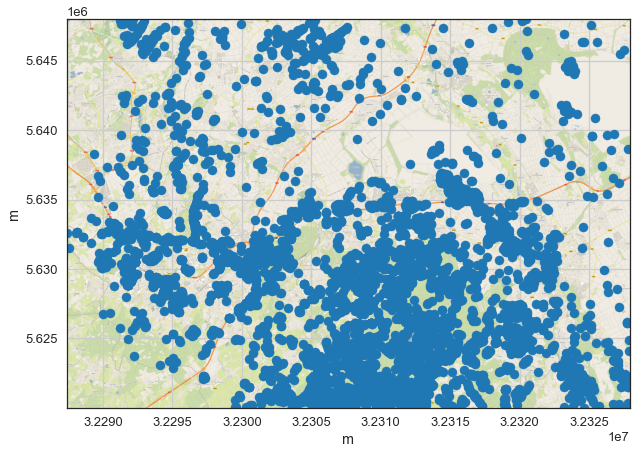

In [8]:
fig, ax1 = plt.subplots()
ax1.imshow(wms_map, extent= [32287388.59,32327922.38,5620005.3,5647999.26])
gdf.plot(ax=ax1)
ax1.grid()
ax1.set_xlabel('m')
ax1.set_ylabel('m')

# Extract Stratigraphic Column from Borehole Logs

Next to the coordinates of the Boreholes, the provided stratigraphic column can also be extracted for the use. 

# Load supplementary Data

In [34]:
with open('../../../gemgis/data/misc/symbols.txt', "r") as text_file:
    symbols = [(i, '') for i in text_file.read().splitlines()]

with open('../../../gemgis/data/misc/formations.txt', "r") as text_file:
    formations = text_file.read().split()
    
formations = [(formations[i], formations[i+1]) for i in range(0,len(formations)-1,2)]
formations[:10]

[('Pliozän:Reuver-Ton,Hor.', 'ReuverFM'),
 ('Pliozän:Reuver-Subformation', 'ReuverFM'),
 ('Pliozän?Reuver-Subformation', 'ReuverFM'),
 ('Pliozän:Reuver-', 'ReuverFM'),
 ('MittlererKeuper', 'MittlererKeuperGP'),
 ('Oligozän:Grafenberg-Formation/Hor.B', 'GrafenbergFM'),
 ('Oligozän:Grafenberg-Formation', 'GrafenbergFM'),
 ('Oligozän:ObereLintfort-Subformation', 'LintfortFM'),
 ('Oligozän:UntereLintfort-Subformation', 'LintfortFM'),
 ('Oligozän:Lintfort-Subformation', 'LintfortFM')]

In [35]:
with open('../../../BoreholeData.txt', "r") as text_file:
    data = text_file.read()

In [36]:
data[:100]

'Stammdaten    -     2521/ 5631/ 1         -          Bnum: 196747  .  .  Objekt / Name :B. 19  ESCHW'

In [37]:
df = gg.misc.stratigraphic_table_list_comprehension(data, 'GD', symbols, formations)

In [46]:
df = df[df['formation']!= 'Quaternary']
df = df[df['formation']!= 'Miocene']
df = df[df['formation']!= 'Oligocene']
df = df[df['formation']!= 'Carboniferous']
df = df[df['formation']!= 'KrebsTraufeFM']
df = df[df['formation']!= 'StolbergFM']
df = df[df['formation']!= 'Tertiary']
df = df[df['formation']!= 'IndenFM']
df = df[df['formation']!= 'NA']
df = df[df['formation']!= 'Paleozoic']
df = df[df['formation']!= 'VilleFM']
df = df[df['formation']!= 'KölnFM']
df = df[df['formation']!= 'BreitgangFM']
df = df[df['formation']!= 'FamennianSchistFM']
df = df[df['formation']!= 'ObererKohlenkalkGP']
df = df[df['formation']!= 'ReuverFM']
df = df[df['formation']!= 'RottonFM']
df = df[df['formation']!= 'MittlererKohlenkalkGP']
df = df[df['formation']!= 'Devonian']
df = df[df['formation']!= 'Pliocene']
df = df[df['formation']!= 'HauptkiesFM']
df = df[df['formation']!= 'WalhornFM']
df = df[df['formation']!= 'KieseloolithFM']
df = df[df['formation']!= 'CondrozGP']
df = df[df['formation']!= 'KnollenkalkFM']
df = df[df['formation']!= 'ObererMassenkalkGP']
df = df[df['formation']!= 'GrafenbergFM']
df = df[df['formation']!= 'LintfortFM']
df = df[df['formation']!= 'WalsumFM']
df = df[df['formation']!= 'RupelFM']
df = df[df['formation']!= 'RatingenFM']
df = df[df['formation']!= 'MittlererKeuperGP']

df.head(50)

,Index,Name,X,Y,Z,Altitude,Depth,formation
114,GD0039,BBERTABINSFELD,32326057.74,5629951.45,113.30,137.00,237.45,Pliozän:Reuver-
141,GD0045,"B.U105a,FeldNiederzier",32323015.05,5641789.40,-171.00,110.00,281.00,Miozän:Kerpen-
149,GD0046,"B.U105,FeldNiederzier",32323205.58,5641380.33,-173.00,111.00,284.00,Miozän:Kerpen-
163,GD0048,"B.U113,FeldNiederzier",32323573.38,5641343.35,-175.00,110.00,285.00,Miozän:Morken-
197,GD0054,"B.U117,FeldNiederzier",32323348.32,5641813.87,-183.00,109.00,292.00,Miozän:Kerpen-
286,GD0081,B.IIISIERSDORF,32304359.03,5643238.84,79.00,117.00,402.50,Pliozän:
304,GD0083,B85VETTWEISS1,32327852.13,5624109.10,64.00,164.00,414.00,Miozän:Fischbach-
307,GD0083,B85VETTWEISS1,32327852.13,5624109.10,-57.00,164.00,414.00,Untermiozän:Morken-
333,GD0090,BANGELSDORF3,32327521.83,5645779.35,39.00,84.00,454.60,"Quaternary,Hor."
413,GD0105,BDUERBOSLARVII,32306621.28,5642506.25,91.00,116.00,554.75,Pliozän:Reuver-


# Plot of classified boreholes